# Final policy notebook
This notebook contains all code used for the report from the Gelderland analysts.

## Loading of model

In [8]:
import os
import random
import shutil
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from ema_workbench import (
    Policy,
    Scenario,
    ema_logging,
    Samplers,
    MultiprocessingEvaluator,
    save_results,
    load_results,
    Constraint,
)
from ema_workbench import Samplers
from ema_workbench.analysis import feature_scoring
from ema_workbench.analysis.scenario_discovery_util import RuleInductionType
from ema_workbench.em_framework.salib_samplers import get_SALib_problem
from SALib.analyze import sobol
from ema_workbench.analysis import prim, parcoords
from ema_workbench.em_framework.optimization import to_problem, ArchiveLogger, EpsilonProgress
from problem_formulation import get_model_for_problem_formulation

ema_logging.log_to_stderr(ema_logging.INFO)

<Logger EMA (DEBUG)>

## Preliminary Sensitivity Analysis

In [ ]:
dike_model, planning_steps = get_model_for_problem_formulation(6)
def get_do_nothing_dict():
    return {l.name: 0 for l in dike_model.levers}

num_scens = 1024
policy = Policy("no release", **get_do_nothing_dict())
with MultiprocessingEvaluator(dike_model) as evaluator:
    results = evaluator.perform_experiments(scenarios=num_scens, policies = policy, uncertainty_sampling = Samplers.SOBOL)

from ema_workbench import save_results
save_results(results, f"{num_scens}_sen_SOBOL_np2.tar.gz")

In [ ]:
results = load_results('1024_sen_SOBOL_np2.tar.gz')
experiments, outcomes = results

rings = ["A.1", "A.2", "A.3", "A.4", "A.5"]
data = pd.DataFrame(outcomes)

In [ ]:
strings = ["_Expected Annual Damage", "_Expected Number of Deaths"]
cols = ["mediumseagreen", "navy", "sandybrown", "crimson", "mediumorchid"]
markers = ["o",6, "s", "D", "v"]
for j in range(len(strings)):
    for i in range(len(rings)):
        
        y = outcomes[f'{rings[i]}{strings[j]}']
        problem = get_SALib_problem(dike_model.uncertainties)
        Si = sobol.analyze(problem, y, calc_second_order=True, print_to_console=False)

        lst = Si.to_df()
        df = pd.concat(lst)
        if i == 0:
            ax = df.plot(y="ST", marker = markers[i], color = cols[i], linestyle = "", rot = 90, figsize = (7,5), label = f"Dike ring {i+1}")
        else:
            df.plot(y="ST", marker = markers[i], color = cols[i], linestyle = "", rot = 90, label = f"Dike ring {i+1}", ax=ax)
    
    ax.set_xticks(range(17))
    ax.set_xticklabels([ind for ind in df.index[:17]], rotation=90)
    ax.grid(visible = True)
    plt.title(f"{strings[j][1:]} per dike ring sensitivity analysis")
    plt.ylabel("Total Sensitivity")
    plt.savefig(f"Sensitivity {strings[j][1:]}")
    plt.show()

## PRIM global sensitivity analysis

In [ ]:
# Return policy for business-as-usual case
dike_model, planning_steps = get_model_for_problem_formulation(2)
def get_do_nothing_dict():
    return {l.name: 0 for l in dike_model.levers}

bau_policy = Policy("no policy", **get_do_nothing_dict())

# Evaluate business-as-usual with SOBOL

with MultiprocessingEvaluator(dike_model) as evaluator:
    results = evaluator.perform_experiments(scenarios=1000, policies=bau_policy, uncertainty_sampling=Samplers.SOBOL)
from ema_workbench import save_results

save_results(results, "Base_scenario_pf2.tar.gz")

[MainProcess/INFO] pool started with 8 workers
C:\Program Files\Python311\Lib\site-packages\scipy\stats\_qmc.py:763: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  sample = self._random(n, workers=workers)
[MainProcess/INFO] performing 36000 scenarios * 1 policies * 1 model(s) = 36000 experiments
 13%|████▌                              | 4662/36000 [08:02<1:01:33,  8.49it/s]

In [3]:
# Load results from previous run
results_bau = "Base_scenario_pf2.tar.gz"
experiments, outcomes = load_results(results_bau)

[MainProcess/INFO] results loaded successfully from C:\Users\Arthur\Documents\GitHub\model-based-decision-making\final assignment\Base_scenario_pf2.tar.gz


[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] 36000 points remaining, containing 1793 cases of interest
[MainProcess/INFO] mean: 0.6513911620294599, mass: 0.050916666666666666, coverage: 0.6659230340211936, density: 0.6513911620294599 restricted_dimensions: 5


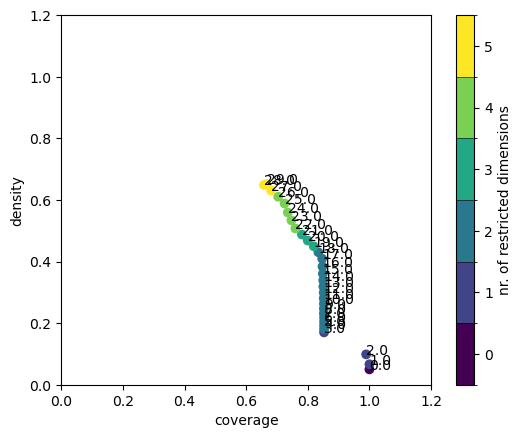

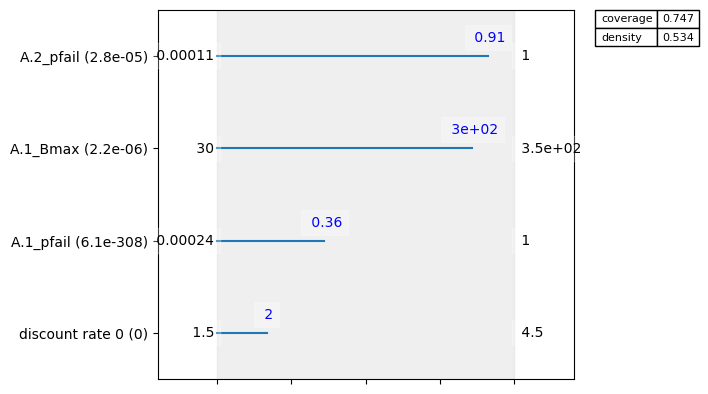

[MainProcess/INFO] resample 0
[MainProcess/INFO] resample 1
[MainProcess/INFO] resample 2
[MainProcess/INFO] resample 3
[MainProcess/INFO] resample 4
[MainProcess/INFO] resample 5
[MainProcess/INFO] resample 6
[MainProcess/INFO] resample 7
[MainProcess/INFO] resample 8
[MainProcess/INFO] resample 9


,reproduce coverage,reproduce density
A.1_Bmax,100.0,100.0
A.1_pfail,100.0,100.0
A.2_pfail,100.0,100.0
discount rate 0,100.0,100.0
A.3_pfail,10.0,10.0
A.4_pfail,10.0,0.0
A.0_ID flood wave shape,0.0,0.0
A.1_Brate,0.0,0.0
A.2_Bmax,0.0,0.0
A.2_Brate,0.0,0.0


In [4]:
# Prim analysis for the 5% highest annual damage outcomes
dike_model, planning_steps = get_model_for_problem_formulation(2)
outcome_of_interest = outcomes['Expected Annual Damage']
x = experiments.drop(labels=[l.name for l in dike_model.levers], axis=1)
y = outcome_of_interest > np.percentile(outcome_of_interest, 95)
prim_alg = prim.Prim(x, y, threshold=0.5, peel_alpha=0.06)
box = prim_alg.find_box()

box.show_tradeoff(annotated=True)
plt.show()

# Pick box 23, which has a relatively high density and interpretability
point = 23
box.inspect(point, style='graph')
box.select(point)
plt.show()

box.resample(point)

In [5]:
# Create reference scenario
lims_as_dict = box.box_lim.to_dict(orient="records")
for i in range(len(lims_as_dict)):
    del lims_as_dict[i]['discount rate 0']

av_dict = {}

for key in lims_as_dict[0].keys():
    av_dict[key] = (lims_as_dict[0][key] + lims_as_dict[1][key]) / 2
    if "Brate" in key or key == "A.0_ID flood wave shape":
        av_dict[key] = np.round(av_dict[key]).astype(int)

ref_scen = Scenario(**av_dict)

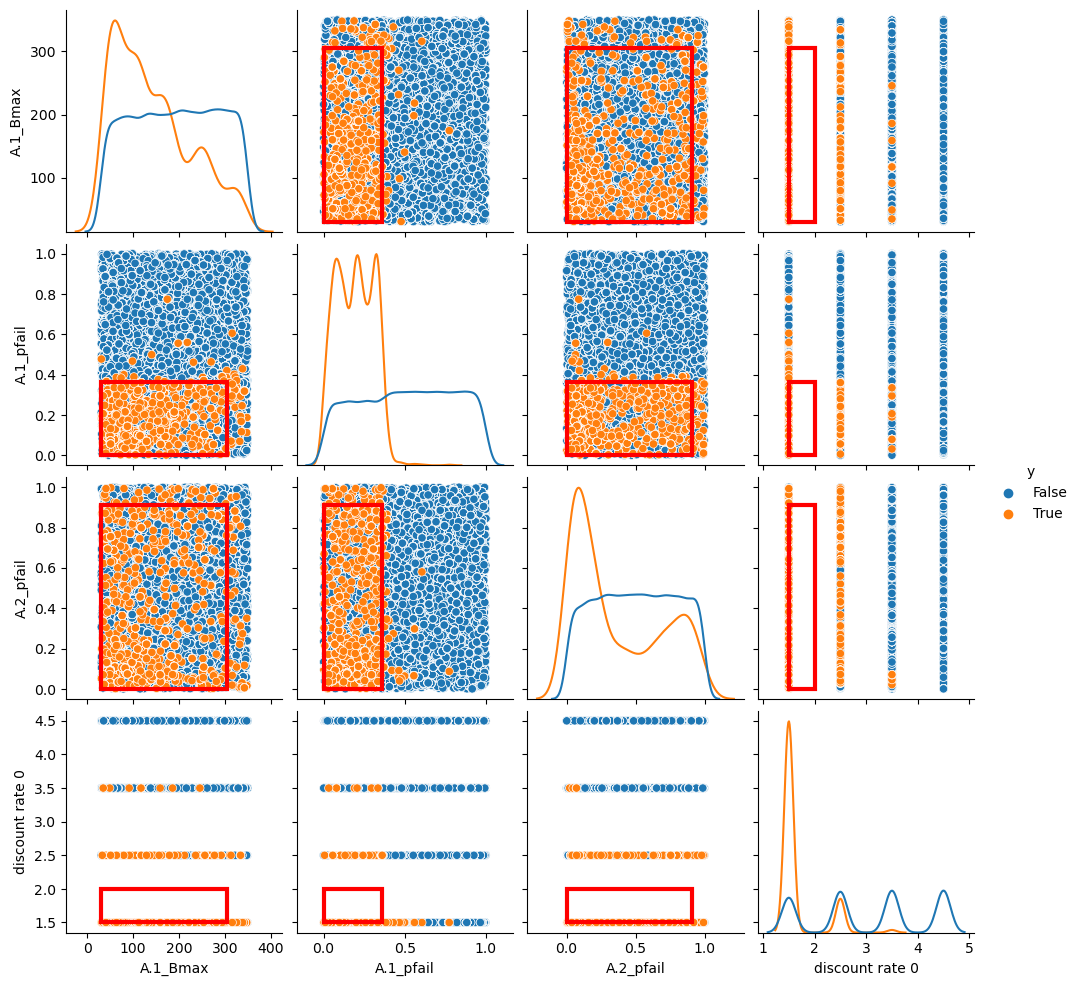

In [6]:
# Show scatter plot with cases of interest in box
box.show_pairs_scatter()
fig = plt.gcf()
plt.show()

## MOEA

In [9]:
MOEA_runs = 1
seed = 1
results = []
convergences = []

nfes = 100 # TODO: set to 100000
eps = [1e6, 5e7, 1e8, 1e6, 0.1] # Values are chosen to obtain ~5 solutions per run
constraints = [Constraint("max damages", outcome_names="Expected Annual Damage", function=lambda x: max(0, x - 5e6))] # Add constraint for 5mln damage maximum

# Find policies in 5 different runs
with MultiprocessingEvaluator(dike_model) as evaluator:
    for i in range(MOEA_runs):
        if os.path.isdir('./tmp'):
            shutil.rmtree('./tmp')

        random.seed(seed)  # Choose seed for reproducibility

        # Save epsilon progress as convergence metric
        convergence_metrics = [
            ArchiveLogger(
                "./",
                [l.name for l in dike_model.levers],
                [o.name for o in dike_model.outcomes],
                base_filename=f"convergence_run{i}.tar.gz"),
            EpsilonProgress()]

        result, convergence = evaluator.optimize(
            nfe=nfes,
            searchover="levers",
            epsilons=eps,
            convergence=convergence_metrics,
            constraints=constraints,
            reference=ref_scen) # Uses the reference scenario obtained earlier with PRIM
        results.append(result)
        convergences.append(convergence)
        
with open(f"convergences_{seed}", "wb") as fp:   #Pickling
    pickle.dump(convergences, fp)



[MainProcess/INFO] pool started with 8 workers
100%|████████████████████████████████████████| 100/100 [00:06<00:00, 15.76it/s]
[MainProcess/INFO] optimization completed, found 3 solutions
[MainProcess/INFO] terminating pool


In [10]:
# Show outcomes and save policy
with open(f"convergences_{seed}", "rb") as fp:   # Unpickling
    convergences = pickle.load(fp)
outcome_keys = np.copy(list(outcomes.keys()))
MOEA_policies = np.array([{} for _ in range(MOEA_runs)])

for run in range(MOEA_runs):
    outcomes = results[run].loc[:,
               ['Expected Annual Damage', 'Dike Investment Costs', 'RfR Investment Costs', 'Evacuation Costs',
                'Expected Number of Deaths']]

    # Save policies
    policies_df = results[run].drop(outcome_keys, axis=1)
    policies_dict = policies_df.to_dict(orient="records")
    MOEA_policies[run] = policies_dict

np.save(f"policies_{seed}.npy", MOEA_policies)

In [ ]:
# Plot tradeoffs in outcomes
scale = 1e6

limits = pd.DataFrame([[0,0,0,0,0],[5,700,700,1,1]], columns=outcome_keys)
axes = parcoords.ParallelAxes(limits)

for i, (result, color) in enumerate(zip(results, sns.color_palette())):
    outcomes = result.loc[:,outcome_keys]
    # Scale costs to millions
    for key in outcome_keys:
        if key != 'Expected Number of Deaths':
            outcomes[key] = outcomes[key] / scale
    axes.plot(outcomes, color=color, label='run {}'.format(i))

axes.legend()
plt.show()
plt.savefig("MOEA runs")


In [ ]:
for i in range(len(convergences)):
    plt.plot(convergences[i].nfe, convergences[i].epsilon_progress)
plt.show()
plt.savefig("epsilon_convergences")

## Evaluate policies

In [ ]:
# Load policies
policies_dict = np.load("policies.npy", allow_pickle=True)
pol_names = [f"pol_{100*i+j}" for i in range(MOEA_runs) for j in range(len(policies_dict[i]))]

### Plotting the obtained policies

In [ ]:
num_scen = 1000 # TODO: set to 1000
policies = [Policy(f"pol_{100*i+j}", **policies_dict[i][j]) for i in range(MOEA_runs) for j in range(len(policies_dict[i])) ]
with MultiprocessingEvaluator(dike_model) as evaluator:
    results_new = evaluator.perform_experiments(num_scen, policies=policies)
save_results(results_new, "re-evaluation.tar.gz")

In [ ]:
results_new = load_results("re-evaluation.tar.gz")
exp_new, out_new = results_new

In [ ]:
measures = [f"{j}_RfR 0" for j in range(5)] + ["EWS_DaysToThreat"] + [f"A.{i + 1}_DikeIncrease 0" for i in range(5)]
policies_list = []
for i in range(len(policies_dict)):
    policies_list.append(list(zip(*map(dict.values, policies_dict[i]))))

distance = 0
end_dist = 0

# Convert the 2D list with tuples into a table
pol_arr = np.zeros((len(measures), len(policies)))
for i in range(len(policies_list)):
    distance = end_dist
    for j in range(len(policies_list[i])):
        temp_dist = distance
        for k in range(len(policies_list[i][j])):
            pol_arr[j,temp_dist] = policies_list[i][j][k]
            temp_dist += 1
        end_dist = temp_dist

pol_arr = pol_arr.T


for (j,i),label in np.ndenumerate(pol_arr):
    plt.text(i,j,int(label),ha='center',va='center')
plt.imshow(pol_arr, cmap = "Blues", vmax = 14)
plt.xticks(np.arange(len(measures)),measures,rotation = 90 )
plt.yticks(np.arange(len(pol_names)), pol_names)
plt.show()
plt.savefig("Policy table")

In [ ]:
# Plot damages with a boxplot per policy
scale = 1e6

outcome = "Expected Annual Damage"
num_pols = len(policies)
plt.figure(figsize = (7,6))
expected_damages_per_pol = np.zeros((num_scen,len(policies)))
for i in range(len(policies)):
    expected_damages_per_pol[:,i] = out_new[outcome][i*num_scen:(i+1)*num_scen]
    plt.boxplot(expected_damages_per_pol/scale, medianprops = dict(color = "black", linewidth = 2),
        patch_artist = True,
            boxprops = dict(facecolor = "mediumseagreen"), flierprops={'marker': 'o', 'markersize': 5, 'markerfacecolor': 'slategrey'})
plt.ylabel("Annual damages (million euros)")
    # plt.xticks(range(1, 6), range(5))
plt.xlabel("Policy")
#plt.yscale("log")
plt.savefig("Annual_damages_final", dpi = 200)
plt.show()

In [ ]:
# Plot deaths with a boxplot per policy
outcome = "Expected Number of Deaths"
num_pols = len(policies)
plt.figure(figsize = (7,6))
deaths_per_pol = np.zeros((num_scen,len(policies)))

for i in range(len(policies)):
    deaths_per_pol[:,i] = out_new[outcome][i*num_scen:(i+1)*num_scen]
    plt.boxplot(deaths_per_pol, medianprops = dict(color = "black", linewidth = 2),
        patch_artist = True,
            boxprops = dict(facecolor = "mediumseagreen"), flierprops={'marker': 'o', 'markersize': 5, 'markerfacecolor': 'slategrey'})
plt.ylabel("Annual deaths")
plt.xlabel("Policy")
plt.savefig("Annual_deaths_final", dpi = 200)
plt.show()

In [ ]:
investments_per_pol = np.zeros((num_scen,len(policies)))
investments = ['Dike Investment Costs', 'RfR Investment Costs', 'Evacuation Costs']

for i in range(len(policies)):
    for j in investments:
        investments_per_pol[:,i] += out_new[j][i*num_scen:(i+1)*num_scen]
x = [*range(len(policies))]
plt.bar(x,investments_per_pol[0,:int(num_pols)]/scale, color = "salmon")
plt.xticks(range(len(policies)), range(len(policies)))
plt.ylabel("Total investment costs (million euros)")
plt.xlabel("Policy")
plt.savefig("Total_investment", dpi = 200)
plt.tight_layout()
plt.show()

### Robustness: Signal to noise

In [ ]:
from ema_workbench import ScalarOutcome

def s_to_n(data, direction):
    mean = np.mean(data)
    std = np.std(data)

    if direction==ScalarOutcome.MAXIMIZE:
        return mean/std
    else:
        return mean*std

In [ ]:
overall_scores = {}
for policy in np.unique(exp_new['policy']):
    scores = {}

    logical = exp_new['policy']==policy

    for outcome in dike_model.outcomes:
        value  = out_new[outcome.name][logical]
        sn_ratio = s_to_n(value, outcome.kind)
        scores[outcome.name] = sn_ratio
    overall_scores[policy] = scores
scores = pd.DataFrame.from_dict(overall_scores).T

In [ ]:
from ema_workbench.analysis import parcoords

df = scores
data=(df-df.min())/(df.max()-df.min())
limits = parcoords.get_limits(data)
data = data.fillna(0.5)
limits.loc[0, [outcome.name for outcome in dike_model.outcomes]] = 0

paraxes = parcoords.ParallelAxes(limits)
paraxes.plot(data)
# paraxes.invert_axis('max_P')
plt.show()
plt.savefig("Robustness")